# Protein 1 


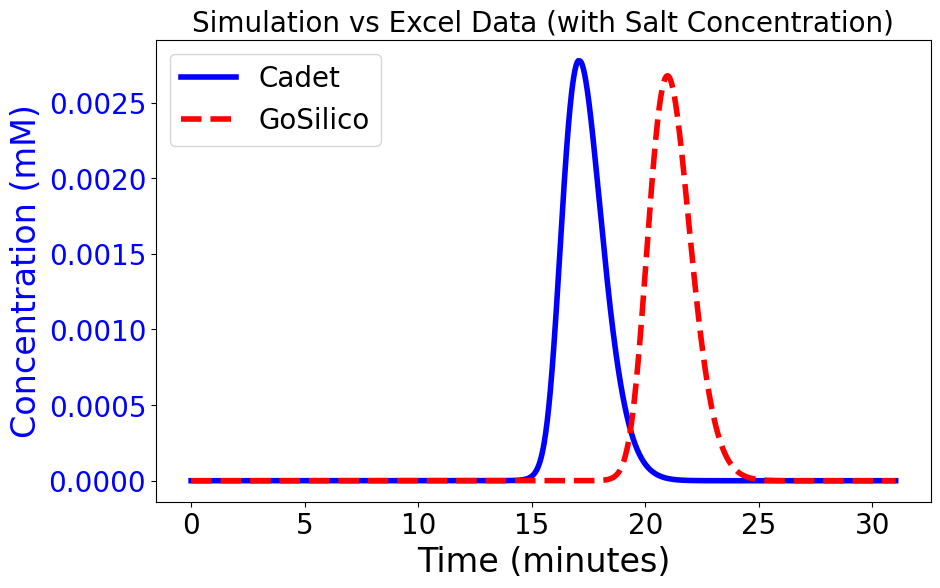

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from CADETProcess.processModel import (
    Inlet, Outlet, LumpedRateModelWithPores,
    HICWaterOnHydrophobicSurfaces, ComponentSystem,
    FlowSheet, Process
)
from CADETProcess.simulator import Cadet
warnings.filterwarnings("ignore")

def run_single_simulation(flow_sheet, Vg, Vl, tag):
    simulator = Cadet()
    process = create_process(flow_sheet, Vg, Vl, tag)
    simulator.timeout = 30
    result = simulator.simulate(process)
    
    return tag, result, process
def create_process(flow_sheet, V_grad, V_load, tag):
    process = Process(flow_sheet, f"{tag}")
    wash_start = V_load / Q_m3_s
    grad_start = wash_start + 5e-6 / Q_m3_s
    grad_end = grad_start + V_grad / Q_m3_s
    sim_state[f"grad_end_{tag}"] = grad_end

    c_load = [starting_salt_conc, 0.00625]
    c_wash = [starting_salt_conc, 0.0]
    c_elute = [75.2968, 0.0]
    slope = (np.array(c_elute) - np.array(c_wash)) / (grad_end - grad_start)
    c_gradient_poly = list(zip(c_wash, slope))

    process.cycle_time = grad_end + 5e-6 / Q_m3_s
    process.add_event('load', 'flow_sheet.inlet.c', c_load)
    process.add_event('wash', 'flow_sheet.inlet.c', c_wash, wash_start)
    process.add_event('grad_start', 'flow_sheet.inlet.c', c_gradient_poly, grad_start)
    process.add_event('elute_start', 'flow_sheet.inlet.c', c_elute, grad_end)
    return process

component_system = ComponentSystem()
component_system.add_component('Salt')
component_system.add_component('Protein1')

binding = HICWaterOnHydrophobicSurfaces(component_system, name='HIC')
binding.is_kinetic = True

equi = 9.76
kinetic = 5.988
b0 = 0.0001048
b1 = 0.0045
keff = 0.01e-3
n = 6.3
qmax = 16.5


Q_ml_min = 0.5
Q_m3_s = Q_ml_min / (60 * 1e6)
CV1 = 0.501437e-6
starting_salt_conc = 2083.45
sim_state = {}

des_rate = 1 / kinetic
ads_rate = des_rate * equi

binding.adsorption_rate = [0.0, ads_rate]
binding.desorption_rate = [0.0, des_rate]
binding.hic_characteristic = [0.0, n]
binding.capacity = [0.0, qmax]
binding.beta_0 = b0
binding.beta_1 = b1
binding.bound_states = [0, 1]

# Column setup
inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = Q_m3_s

column = LumpedRateModelWithPores(component_system, name='column')
column.binding_model = binding
column.length = 0.02
column.diameter = 0.00565
column.bed_porosity = 0.30
column.particle_radius = 4.5e-05
column.particle_porosity = 0.7571
column.axial_dispersion = 0.056e-6
column.film_diffusion = [0.01e-3, keff]
column.c = [starting_salt_conc, 0]
column.cp = [starting_salt_conc, 0]
column.q = [0]
column.discretization.ncol = 35

outlet = Outlet(component_system, name='outlet')

flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

Vg, Vl, tag = 10 * CV1, 0.5e-6, 0

try:
    tag, result, process = run_single_simulation(flow_sheet, Vg, Vl, tag)
    sim_time = result.solution.outlet.outlet.time / 60  
    sim_concentration = result.solution.outlet.outlet.total_concentration_components[:, 1]
    sim_salt=result.solution.outlet.outlet.total_concentration_components[:, 0]
except Exception as e:
    print("Simulation failed:", e)

excel_file_path = 'hic_10_pro1.xlsx'
excel_data = pd.read_excel(excel_file_path)

time_from_excel = excel_data['Time [min]']
concentration_from_excel = excel_data['Biomolecule Concentration [mM]']


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(sim_time, sim_concentration, label="Cadet", color='b')
ax1.plot(time_from_excel, concentration_from_excel, label="GoSilico", color='r', linestyle='--')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Concentration (mM)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.title('Simulation vs Excel Data (with Salt Concentration)')
ax1.legend(loc='upper left')

plt.show()

# Protein 2

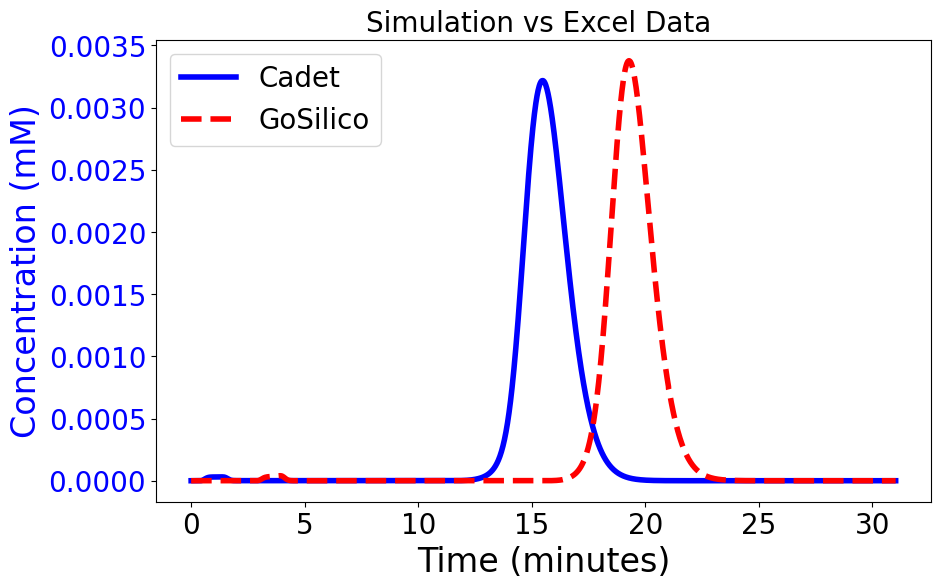

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from CADETProcess.processModel import (
    Inlet, Outlet, LumpedRateModelWithPores,
    HICWaterOnHydrophobicSurfaces, ComponentSystem,
    FlowSheet, Process
)
from CADETProcess.simulator import Cadet
import time
import gc

warnings.filterwarnings("ignore")

def run_single_simulation(flow_sheet, Vg, Vl, tag):
    simulator = Cadet()
    process = create_process(flow_sheet, Vg, Vl, tag)
    simulator.timeout = 600
    simulator.abs_tol = 1e-10
    result = simulator.simulate(process)
    
    return tag, result, process
def create_process(flow_sheet, V_grad, V_load, tag):
    process = Process(flow_sheet, f"{tag}")
    wash_start = V_load / Q_m3_s
    grad_start = wash_start + 5e-6 / Q_m3_s
    grad_end = grad_start + V_grad / Q_m3_s
    sim_state[f"grad_end_{tag}"] = grad_end

    c_load = [starting_salt_conc, 0.00757576]
    c_wash = [starting_salt_conc, 0.0]
    c_elute = [75.2968, 0.0]
    slope = (np.array(c_elute) - np.array(c_wash)) / (grad_end - grad_start)
    c_gradient_poly = list(zip(c_wash, slope))

    process.cycle_time = grad_end + 5e-6 / Q_m3_s
    process.add_event('load', 'flow_sheet.inlet.c', c_load)
    process.add_event('wash', 'flow_sheet.inlet.c', c_wash, wash_start)
    process.add_event('grad_start', 'flow_sheet.inlet.c', c_gradient_poly, grad_start)
    process.add_event('elute_start', 'flow_sheet.inlet.c', c_elute, grad_end)
    return process

component_system = ComponentSystem()
component_system.add_component('Salt')
component_system.add_component('Protein1')

binding = HICWaterOnHydrophobicSurfaces(component_system, name='HIC')
binding.is_kinetic = True

equi = 6.7
kinetic = 9.73
b0 = 5e-05
b1 = 0.00450
keff = 0.01e-3
n = 5.2
qmax = 22

Q_ml_min = 0.5
Q_m3_s = Q_ml_min / (60 * 1e6)
CV1 = 0.501437e-6
starting_salt_conc = 2083.45
sim_state = {}

des_rate = 1 / kinetic
ads_rate = des_rate * equi

binding.adsorption_rate = [0.0, ads_rate]
binding.desorption_rate = [0.0, des_rate]
binding.hic_characteristic = [0.0, n]
binding.capacity = [0.0, qmax]
binding.beta_0 = b0
binding.beta_1 = b1
binding.bound_states = [0, 1]

inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = Q_m3_s

column = LumpedRateModelWithPores(component_system, name='column')
column.binding_model = binding
column.length = 0.02
column.diameter = 0.00565
column.bed_porosity = 0.30
column.particle_radius = 4.5e-05
column.particle_porosity = 0.7571
column.axial_dispersion = 0.056e-6
column.film_diffusion = [0.01e-3, keff]
column.c = [starting_salt_conc, 0]
column.cp = [starting_salt_conc, 0]
column.q = [0]
column.discretization.ncol = 50

outlet = Outlet(component_system, name='outlet')

flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

Vg, Vl, tag = 10 * CV1, 0.5e-6, 0

try:
    tag, result, process = run_single_simulation(flow_sheet, Vg, Vl, tag)
    sim_time = result.solution.outlet.outlet.time / 60  
    sim_concentration = result.solution.outlet.outlet.total_concentration_components[:, 1]
    sim_salt=result.solution.outlet.outlet.total_concentration_components[:, 0]
except Exception as e:
    print("Simulation failed:", e)

excel_file_path = 'hic_10_pro2.xlsx'
excel_data = pd.read_excel(excel_file_path)

time_from_excel = excel_data['Time [min]']
concentration_from_excel = excel_data['Biomolecule Concentration [mM]']


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(sim_time, sim_concentration, label="Cadet", color='b')
ax1.plot(time_from_excel, concentration_from_excel, label="GoSilico", color='r', linestyle='--')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Concentration (mM)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

plt.title('Simulation vs Excel Data ')
ax1.legend(loc='upper left')
plt.show()

# Protein 3  

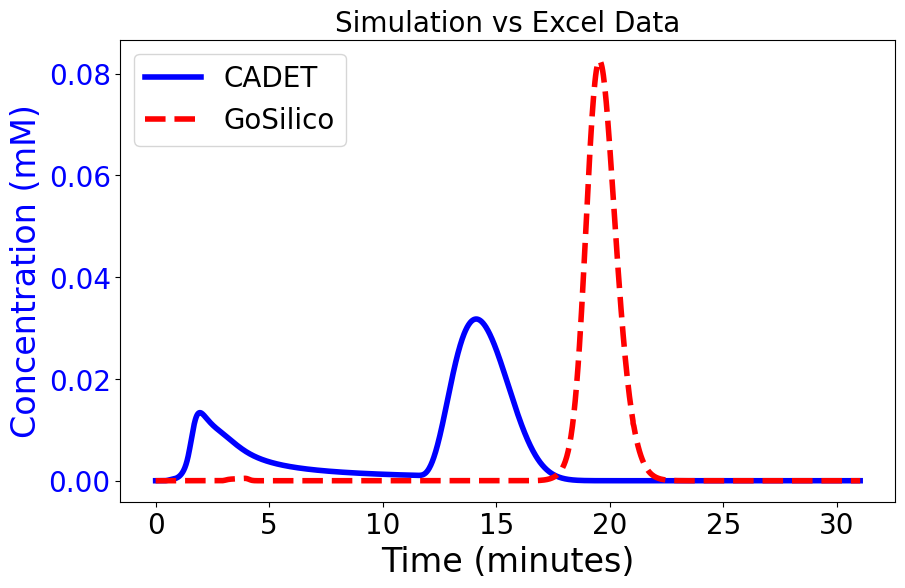

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from CADETProcess.processModel import (
    Inlet, Outlet, LumpedRateModelWithPores,
    HICWaterOnHydrophobicSurfaces, ComponentSystem,
    FlowSheet, Process
)
from CADETProcess.simulator import Cadet
warnings.filterwarnings("ignore")

def run_single_simulation(flow_sheet, Vg, Vl, tag):
    simulator = Cadet()
    process = create_process(flow_sheet, Vg, Vl, tag)
    simulator.timeout = 6
    result = simulator.simulate(process)
    
    return tag, result, process
def create_process(flow_sheet, V_grad, V_load, tag):
    process = Process(flow_sheet, f"{tag}")
    wash_start = V_load / Q_m3_s
    grad_start = wash_start + 5e-6 / Q_m3_s
    grad_end = grad_start + V_grad / Q_m3_s
    sim_state[f"grad_end_{tag}"] = grad_end

    c_load = [starting_salt_conc, 0.136986]
    c_wash = [starting_salt_conc, 0.0]
    c_elute = [75.2968, 0.0]
    slope = (np.array(c_elute) - np.array(c_wash)) / (grad_end - grad_start)
    c_gradient_poly = list(zip(c_wash, slope))

    process.cycle_time = grad_end + 5e-6 / Q_m3_s
    process.add_event('load', 'flow_sheet.inlet.c', c_load)
    process.add_event('wash', 'flow_sheet.inlet.c', c_wash, wash_start)
    process.add_event('grad_start', 'flow_sheet.inlet.c', c_gradient_poly, grad_start)
    process.add_event('elute_start', 'flow_sheet.inlet.c', c_elute, grad_end)
    return process

component_system = ComponentSystem()
component_system.add_component('Salt')
component_system.add_component('Protein3')

binding = HICWaterOnHydrophobicSurfaces(component_system, name='HIC')
binding.is_kinetic = 1

equi = 3.89
kinetic = 4.935
b0 = 0.0001048
b1 = 0.00450
keff = 0.01e-3
n = 7.6
qmax = 48.7


Q_ml_min = 0.5
Q_m3_s = Q_ml_min / (60 * 1e6)
CV1 = 0.501437e-6
starting_salt_conc = 2083.45
sim_state = {}

des_rate = 1 / kinetic
ads_rate = des_rate * equi

binding.adsorption_rate = [0.0, ads_rate]
binding.desorption_rate = [0.0, des_rate]
binding.hic_characteristic = [0.0, n]
binding.capacity = [0.0, qmax]
binding.beta_0 = b0
binding.beta_1 = b1
binding.bound_states = [0, 1]

inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = Q_m3_s

column = LumpedRateModelWithPores(component_system, name='column')
column.binding_model = binding
column.length = 0.02
column.diameter = 0.00565
column.bed_porosity = 0.30
column.particle_radius = 4.5e-05
column.particle_porosity = 0.7571
column.axial_dispersion = 0.056e-6
column.film_diffusion = [0.01e-3, keff]
column.c = [starting_salt_conc, 0]
column.cp = [starting_salt_conc, 0]
column.q = [0]
column.discretization.ncol = 50

outlet = Outlet(component_system, name='outlet')


flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

Vg, Vl, tag = 10 * CV1, 0.5e-6, 0

try:
    tag, result, process = run_single_simulation(flow_sheet, Vg, Vl, tag)
    sim_time = result.solution.outlet.outlet.time / 60  # Convert to minutes
    sim_concentration = result.solution.outlet.outlet.total_concentration_components[:, 1]
    sim_salt=result.solution.outlet.outlet.total_concentration_components[:, 0]
except Exception as e:
    print("Simulation failed:", e)

excel_file_path = 'hic_10_pro3.xlsx'
excel_data = pd.read_excel(excel_file_path)

time_from_excel = excel_data['Time [min]']
concentration_from_excel = excel_data['Biomolecule Concentration [mM]']


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(sim_time, sim_concentration, label="CADET", color='b')
ax1.plot(time_from_excel, concentration_from_excel, label="GoSilico", color='r', linestyle='--')

ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Concentration (mM)', color='b')
ax1.tick_params(axis='y', labelcolor='b')



plt.title('Simulation vs Excel Data')
ax1.legend(loc='upper left')
plt.show()